# Finite-Volume Methods for Shocktube Problems

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import pyflow
from pyflow.euler import PrimitiveState
from pyflow.euler.shocktube import ShocktubeProblem

# One-dimensional Shock Tube Problems

In this notebook, several finite-volume numerical alogirthms are presented for solving the 1-D Euler equations on the shock tube problem.  The shock tube problem consists of a flow at rest with a diaphragm separating two uniform regions at different densities and pressures. Upon removing the diaphragm at $t = t_0$, a shock wave travels into the low pressure side leaving a rarefaction in its wake. Between the rarefaction fan and the shock wave is a contact discontinuity forms, which is a remnant of the differences in the densities initially across the diaphragm. Both the pressure and velocity are constant across a contact discontinuity, which moves at the local velocity. The gas dynamics are often illustrated using a $x$-$-t$ diagram, which traces the location of the rarefaction, contact, and shock waves.

<img src="shocktube.png" alt="shocktube.png" width="500" height="300">


The shock tube problem is often used to test numerical algorithms for compressible flows. In this notebook, the Sod shocktube test case is solved using MacCormack's second-order, predictor-corrector method, which is compared to more sophisticated methods that are usually required for flows exhibiting shock waves and/or high pressure and density gradients. 

## Euler Equations 

The Euler equations in one-dimension are given as

$$
\begin{align}
& \frac{\partial \rho}{\partial t} + \frac{\partial \rho u}{\partial x} = 0 \\
& \frac{\partial \rho u}{\partial t} + \frac{\partial (\rho u^2 + p)}{\partial x} = 0 \\
& \frac{\partial \rho e}{\partial t} + \frac{\partial}{\partial x}\Big[ \left(e + p\right)u \Big] = 0
\end{align}
$$

which can be written in conservation law form

$$
\frac{\partial \mathbf{U} }{\partial t} + \frac{\partial \mathbf{F}}{\partial x} = 0
$$

where $\mathbf{U}$ is the vector of conserved variables and $\mathbf{F}(\mathbf{U})$ is the vector of fluxes. In general, these definition can be extended to any $m$-number of conservation laws and dimensions; however, for the one-dimensional Euler equations specifically we have

$$
\mathbf{U} = \begin{bmatrix}
\rho \\
\rho u \\
e 
\end{bmatrix}
$$

and

$$
\mathbf{F} = \begin{bmatrix}
\rho u\\
\rho u^2 + p \\
 u (e + p)
\end{bmatrix}
$$

with 

$$
p = (\gamma - 1)\left(e - \rho \frac{u^2}{2}\right)
$$

## MacCormack Method

MacCormck's method is a two-step, predictor-corrector method. In the predictor step, a forward difference approximation is used for the spatial derivative of the flux, which is then followed by a backward difference in the corrector step. The averaging of the spatial differences at the predictor ($t = n\Delta t$) and the corrector ($t = (n+1)\Delta t$) makes the method centered in both time and space. Thus, MacCormack's method is both second-order in space and time. 

In one-dimension and assuming uniform spacing of the computational mesh, the method can be simplified to the following two-step, difference equations.

$$
\begin{align}
\textrm{predictor: } \qquad U^{\overline{n+1}}_i & = U^n_i - \frac{\Delta t}{\Delta x} \Big(F^n_{i+\frac{1}{2}} - F^n_{i-\frac{1}{2}} \Big) & \\
\textrm{corrector: } \qquad U^{n+1}_i & = \frac{1}{2} \left[ U^n_i + U^{\overline{n+1}}_i - \frac{\Delta t}{\Delta x} \Big(F^{\overline{n+1}}_{j+1} - F^{\overline{n+1}}_j \Big) \right]
\end{align}
$$

The indexing notations for the cell-centered variables, $U_i$, and the corresponding face-centered fluxes at the left $F^n_{i-\frac{1}{2}}$ and right $F^n_{i+\frac{1}{2}}$ of the $i^{th}$-element are shown in the figure below. 


<img src="fvm.png" alt="fvm.png" width="500" height="300">

Note any finite-volume method requires an algorithm for computing the face-centered fluxes. This requires reconstructing the cell-centered quantities at each of the faces within the computational mesh. For MacCormack's method, this reconstruction process is linear.

In previous discussions when deriving the finite-volume method, we defined fluxes using the $j^{th}$ face of the volume element. In one-dimension, we can simplify the notation and use the half-mesh spacings as shown in the above figure. Since the volume-averaged conserved variables, $U_i$, are not defined at the surfaces of the volume element or cell, they must be reconstructed. For the MacCormack method, at the predictor step the values at the face are forward-biased as

$$
F^n_{i+\frac{1}{2}} = F^n \,\Big(U^n_{i+1}\Big) 
$$

and

$$
F^n_{i-\frac{1}{2}} = F^n \,\Big(U^n_{i}\Big) 
$$

and at the corrector step, the values at the face are backward-biased as

$$
F^{\overline{n+1}}_{i+\frac{1}{2}} = F^n \,\Big(U^{\overline{n+1}}_{i}\Big) 
$$

and

$$
F^{\overline{n+1}}_{i-\frac{1}{2}} = F^n \,\Big(U^{\overline{n+1}}_{i-1}\Big) 
$$

Since the Euler fluxes are expressed as functions of the primitive variables, they must be recomputed from the conservative vector. In particular, the pressure is required. The Euler flux vector is given as

$$
\mathbf{f} = \begin{bmatrix}
    \rho u & \\
    \rho u^2 + p & \\
    (e + p) u 
  \end{bmatrix}
$$

From the conservative variables, the primitive variables can be computed, which requires a thermodynamic model to relate the total energy to the thermodynamic state. For a calorically-perfect gas, this relationship is straight-forward and the mapping between the conservative and primitive variables is linear.  
$$
\mathbf{U}^n_i = \begin{bmatrix}
    \rho^n_i & \\
    (\rho u)^n_i & \\
    e^n_i 
  \end{bmatrix} \to
\mathbf{V}^n_i = \begin{bmatrix}
    \rho^n_i & \\
    p^n_i & \\
    T^n_i 
  \end{bmatrix}
$$ 

For a calorically perfect gas, the velocity is first computed using the momentum and total density as, 
$$
u^n_i = \frac{(\rho u)^n_i}{\rho^n_i}
$$
Next, the internal energy or temperature is computed

$$
\epsilon^n_i = c^n_{v,i} T^n_i = \frac{e^n_i}{\rho^n_i} - \frac{1}{2} (u^n_i )^2
$$

And last we can compute the pressure,
$$
p^n_i = (\gamma - 1) \rho^n_i \epsilon^n_i
$$

## Shocktube Test Cases

Shocktube test cases are a standard way of testing the performance of compressible CFD solvers. For an extensive review of test problems for the Euler equations see the accompanying paper by Liska and Wendroff, 2003. 

## Sod Test Case


For use with `pyflow` a shocktube problem is defined by specifying the primitive state vector at the left and right of the diaphragm. To do this, use the `PrimitiveState` object. For example, the following code defines the left and right state vectors.

    left = euler.PrimitiveState(density=1.0, speed=0.0, pressure=1.0)
    right = euler.PrimitiveState(density=0.125, speed=0.0, pressure=0.1)

These can then be used to define a shocktube problem:

    Sod = ShocktubeProblem(left, right, x0=0.5, Nx=50)

where `x0` is the location of the diaphragm and `Nx` is the number of cells used to discretize the domain. Additionally, the specific heat ratio $\gamma$ can also be specified. For example, to change the value of the specific heat ratio from the default of 1.4 to $\gamma = 5/3$, 


    Sod = ShocktubeProblem(left, right, x0=0.5, Nx=50, gamma=5/3)

In [3]:
# Define the left and right states for the initial conditions of Sod's shocktube test case
#
left = PrimitiveState(density=1.0, speed=0.0, pressure=1.0)
right = PrimitiveState(density=0.125, speed=0.0, pressure=0.1)

# Number of cells
Nx = 100

# CFL number
CFL = 0.8

# Diaphragm location
x0 = 0.5

# Final simulation time
#
time = 0.25

In [4]:
SodExact = ShocktubeProblem(left, right, method='exact', x0=x0, Nx=Nx, CFL=CFL)
exact = SodExact.solve(time)

2022-05-07 05:14:25,321 | pyflow.euler.shocktube | INFO | Compute exact solution to shocktube problem only.


In [5]:
# Compute the solution using MacCormack's predictor-corrector method
#
SodMC = ShocktubeProblem(left, right, method='maccormack', x0=x0, Nx=Nx, CFL=CFL)

MC = SodMC.solve(time)

2022-05-07 05:14:25,883 | pyflow.euler.shocktube | INFO | Finite-volume method selected: MacCormack predictor-correct


Simulation Complete
Final time = 0.25
Total number of iterations = 77


<IPython.core.display.Javascript object>


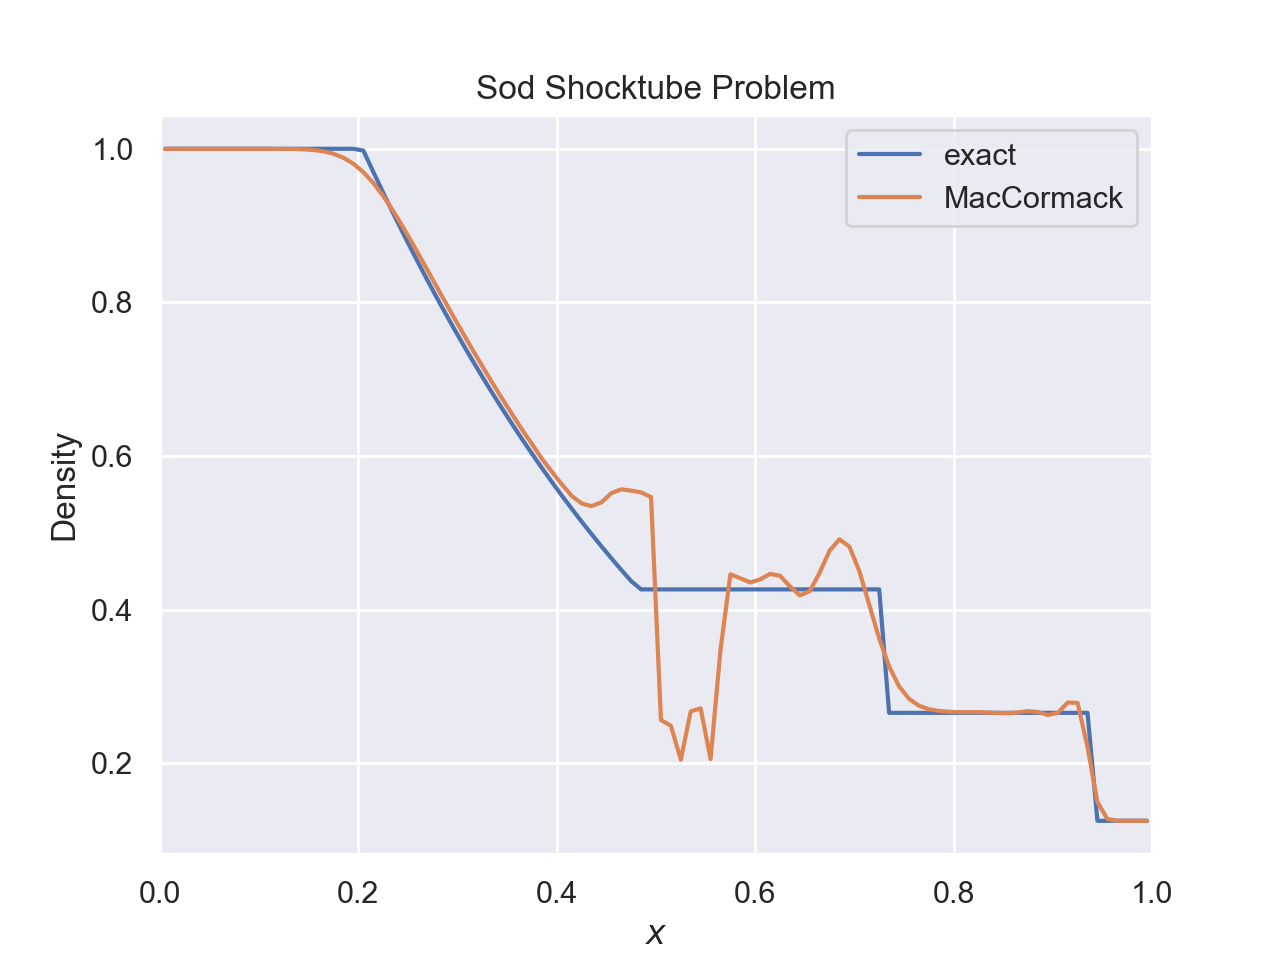

Text(0.5, 1.0, 'Sod Shocktube Problem')

In [6]:
fig, ax = plt.subplots()
ax.plot(exact.x, exact.density, label="exact")
ax.plot(MC.x, MC.density, label="MacCormack")

ax.set_xlabel(r'$x$')
ax.set_ylabel('Density')
ax.set_xlim((0,1))
ax.legend()
plt.title('Sod Shocktube Problem')

There are significant oscillations in the solution using MacCormack's methods, particularly at the discontinuities. In some instances for a given mesh spacing and time step, MacCormack's method can fail. This non-monotonic behavior is unavoidable for any second-order or higher numerical method that uses linear reconstruction functions for the numerical fluxes. Recall that similar observations were made about the finite-difference methods. See Godunov's order barrier theorem.

An early solution to this problem was the inclusion of the numerical dissipation; however, this approach is not ideal because the numerical dissipation is applied to all parts of the flow, when it only needs to be applied to regions of high gradients. Observe how the inclusion of numerical dissipation helps stabilize MacCormack's method.

In [7]:
# Compute the solution using MacCormack's predictor-corrector method
#
SodMCdiss = ShocktubeProblem(left, right, method='maccormack', x0=x0, Nx=Nx, CFL=CFL, dissipation=0.1)

MCdiss = SodMCdiss.solve(time)

2022-05-07 05:14:27,865 | pyflow.euler.shocktube | INFO | Finite-volume method selected: MacCormack predictor-correct


Simulation Complete
Final time = 0.25
Total number of iterations = 68


<IPython.core.display.Javascript object>


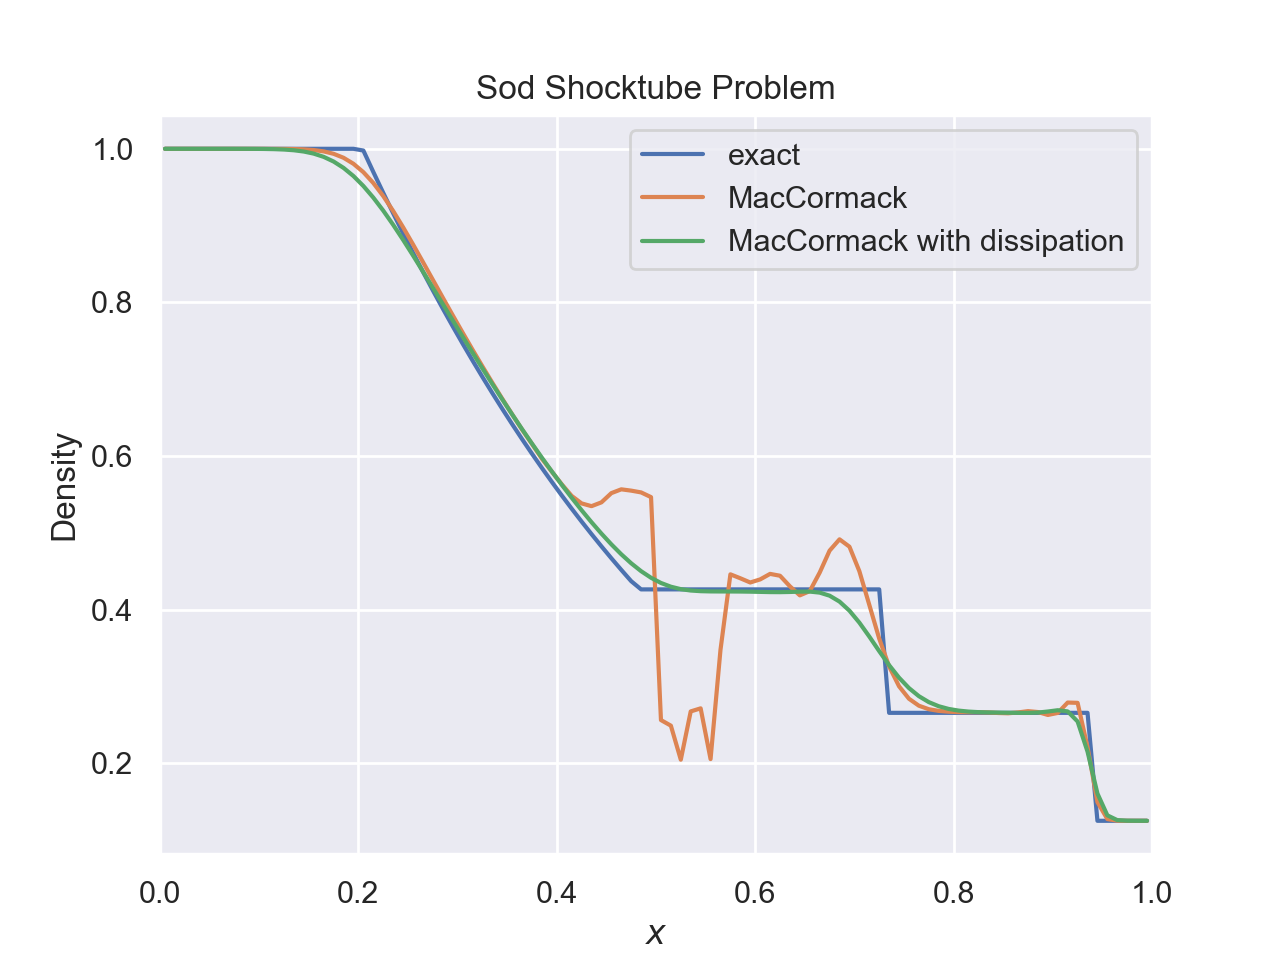

Text(0.5, 1.0, 'Sod Shocktube Problem')

In [8]:
fig, ax = plt.subplots()
ax.plot(exact.x, exact.density, label="exact")
ax.plot(MC.x, MC.density, label="MacCormack")
ax.plot(MCdiss.x, MCdiss.density, label="MacCormack with dissipation")

ax.set_xlabel(r'$x$')
ax.set_ylabel('Density')
ax.set_xlim((0,1))
ax.legend()
plt.title('Sod Shocktube Problem')

Computational scientists discovered that *non-linear* reconstructions were necessary for developing high-order methods for compressible flows. These non-linear reconstructions form the basis for the flux-differencing and flux-vector splitting algorithms that are illustrated below.

In [9]:
# Compute the solution using MacCormack's predictor-corrector method
#
SodSW = ShocktubeProblem(left, right, method='steger-warming', x0=x0, Nx=Nx, CFL=CFL)

SW = SodSW.solve(time)

2022-05-07 05:14:29,888 | pyflow.euler.shocktube | INFO | Finite-volume method selected: Steger-Warming


Simulation Complete
Final time = 0.25
Total number of iterations = 68


In [10]:
# Compute the solution using MacCormack's predictor-corrector method
#
SodHLLC = ShocktubeProblem(left, right, method='hllc', x0=x0, Nx=Nx, CFL=CFL)

HLLC = SodHLLC.solve(time)

2022-05-07 05:14:30,677 | pyflow.euler.shocktube | INFO | Finite-volume method selected: Flux-difference splitting, HLLC


Simulation Complete
Final time = 0.25
Total number of iterations = 67


<IPython.core.display.Javascript object>


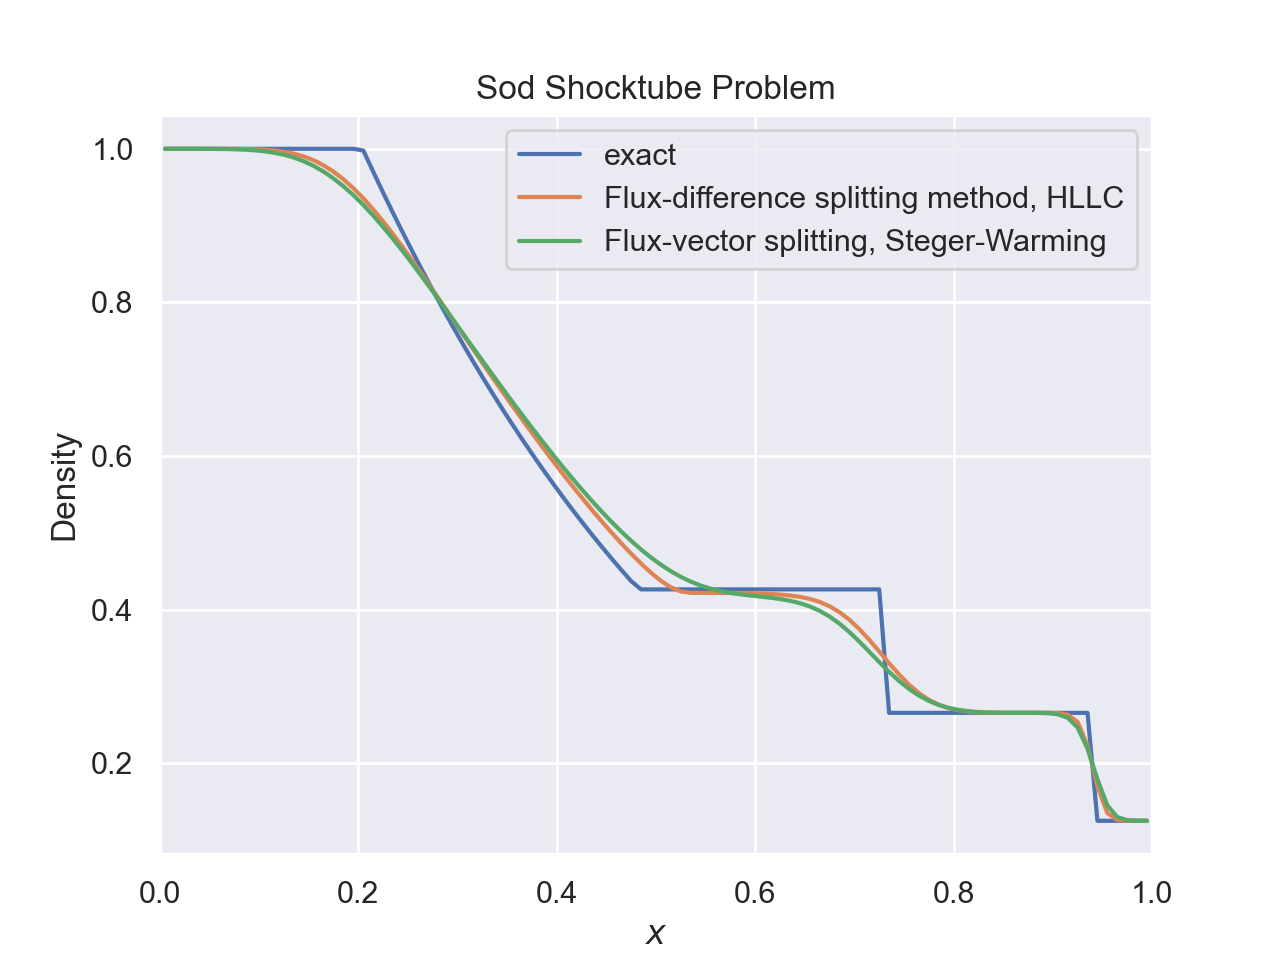

Text(0.5, 1.0, 'Sod Shocktube Problem')

In [11]:
fig, ax = plt.subplots()
ax.plot(exact.x, exact.density, label="exact")
ax.plot(HLLC.x, HLLC.density, label="Flux-difference splitting method, HLLC")
ax.plot(SW.x, SW.density, label="Flux-vector splitting, Steger-Warming")

ax.set_xlabel(r'$x$')
ax.set_ylabel('Density')
ax.set_xlim((0,1))
ax.legend()
plt.title('Sod Shocktube Problem')

# References

1. Liska, R. and B. Wendroff (2003), *Comparison of several difference schemes on 1D and 2D test problems for the Euler equations*, SIAM J. Sci. Comput., **25** (3), 995-1017